In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression


plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


df = pd.read_csv("input_data/autos.csv", na_values='?')

In [4]:
features = ["highway-mpg", "engine-size", "horsepower", "curb-weight"]

X = df.copy()
X = X.dropna(subset=features+['price'])
y = X.pop('price')
X = X.loc[:, features]

# Standardize
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [5]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4
0,0.394715,-0.373767,0.071735,0.188581
1,0.394715,-0.373767,0.071735,0.188581
2,1.575528,-0.162638,0.584698,-0.244818
3,-0.397286,-0.420214,0.188498,0.033906
4,1.145809,-0.736098,-0.311617,0.254685


In [6]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4
highway-mpg,-0.487876,0.742190,0.173483,-0.425481
engine-size,0.499975,0.636174,0.103199,0.578496
horsepower,0.504585,-0.099568,0.726225,-0.456154
curb-weight,0.507342,0.185804,-0.657153,-0.525577


array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='component'>],
      dtype=object)

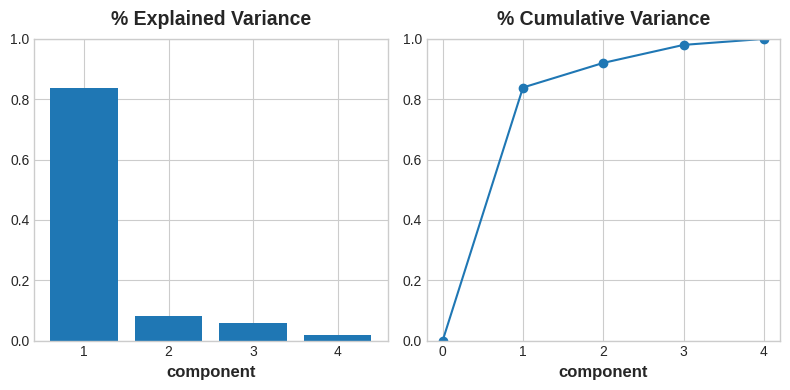

In [7]:
# Look at explained variance
plot_variance(pca)

In [8]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC1    0.990770
PC2    0.350752
PC3    0.221004
PC4    0.134155
Name: MI Scores, dtype: float64

In [10]:
# Show dataframe sorted by PC3
idx = X_pca["PC3"].sort_values(ascending=False).index
cols = ["make", "body-style", "horsepower", "curb-weight"]
df.loc[idx, cols]

,make,body-style,horsepower,curb-weight
123,plymouth,wagon,88.0,2535
124,plymouth,hatchback,145.0,2818
125,porsche,hatchback,143.0,2778
46,isuzu,hatchback,90.0,2734
102,nissan,wagon,152.0,3296
...,...,...,...,...
106,nissan,hatchback,160.0,3139
110,peugot,wagon,95.0,3430
107,peugot,sedan,97.0,3020
111,peugot,sedan,95.0,3075


<AxesSubplot:xlabel='sports_or_wagon', ylabel='price'>

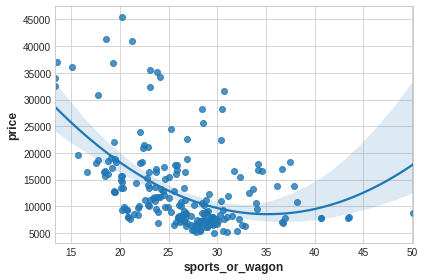

In [13]:
df["sports_or_wagon"] = X['curb-weight'] / X.horsepower
sns.regplot(x="sports_or_wagon", y='price', data=df, order=2)